## Import section

In [1]:
import numpy as np
import json
import os
import seaborn as sns
import pandas as pd
from graphviz import Graph
import uuid
import tensorflow as tf
import copy

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin

from tensorflow.keras.layers import LSTM, Dense, Input, TimeDistributed
from tensorflow.keras import Model

In [149]:
%load_ext tensorboard

# Data Loading

In [2]:
os.getcwd()

'/home/jan/kaggle_competitions/covid'

In [3]:
raw_train_valid_ds = pd.read_json('./train.json', lines=True)
raw_test_ds = pd.read_json('./test.json', lines=True)
sample_submission = pd.read_csv('./sample_submission.csv')

In [4]:
raw_train_valid_ds.head()

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


In [5]:
raw_test_ds.head()

,index,id,sequence,structure,predicted_loop_type,seq_length,seq_scored
0,0,id_00073f8be,GGAAAAGUACGACUUGAGUACGGAAAACGUACCAACUCGAUUAAAA...,......((((((((((.(((((.....))))))))((((((((......,EEEEEESSSSSSSSSSBSSSSSHHHHHSSSSSSSSSSSSSSSSHHH...,107,68
1,1,id_000ae4237,GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAU...,.....((((..((((((...(((((.....((((....)))).......,EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIII...,130,91
2,2,id_00131c573,GGAAAACAAAACGGCCUGGAAGACGAAGGAAUUCGGCGCGAAGGCC...,...........((.(((.(.(..((..((..((((...))))..))...,EEEEEEEEEEESSISSSISISIISSIISSIISSSSHHHSSSSIISS...,107,68
3,3,id_00181fd34,GGAAAGGAUCUCUAUCGAAGGAUAGAGAUCGCUCGCGACGGCACGA...,......((((((((((....))))))))))((((((..((.(((.....,EEEEEESSSSSSSSSSHHHHSSSSSSSSSSSSSSSSIISSISSSHH...,107,68
4,4,id_0020473f7,GGAAACCCGCCCGCGCCCGCCCGCGCUGCUGCCGUGCCUCCUCUCC...,.....(((((((((((((((((((((((((((((((((((((((((...,EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,130,91


In [6]:
sample_submission.head()

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.0,0.0,0.0,0.0,0.0
1,id_00073f8be_1,0.0,0.0,0.0,0.0,0.0
2,id_00073f8be_2,0.0,0.0,0.0,0.0,0.0
3,id_00073f8be_3,0.0,0.0,0.0,0.0,0.0
4,id_00073f8be_4,0.0,0.0,0.0,0.0,0.0


In [7]:
train_valid_example = raw_train_valid_ds.iloc[0,:]
print("TRAIN-VALID EXAMPLE")
print()
print(train_valid_example)

print('\n\n\n')

test_example = raw_test_ds.iloc[0,:]
print("TEST EXAMPLE")
print()
print(test_example)

TRAIN-VALID EXAMPLE

index                                                                  0
id                                                          id_001f94081
sequence               GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...
structure              .....((((((.......)))).)).((.....((..((((((......
predicted_loop_type    EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...
signal_to_noise                                                    6.894
SN_filter                                                              1
seq_length                                                           107
seq_scored                                                            68
reactivity_error       [0.1359, 0.20700000000000002, 0.1633, 0.1452, ...
deg_error_Mg_pH10      [0.26130000000000003, 0.38420000000000004, 0.1...
deg_error_pH10         [0.2631, 0.28600000000000003, 0.0964, 0.1574, ...
deg_error_Mg_50C       [0.1501, 0.275, 0.0947, 0.18660000000000002, 0...
deg_error_50C          [0.2167

In [8]:
feature_names = ['sequence', 'structure', 'predicted_loop_type']
error_label_names = ['reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10', 'deg_error_Mg_50C', 'deg_error_50C']
normal_label_names = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
all_label_names = error_label_names + normal_label_names
important_label_names = ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C']

In [9]:
print(f"sequence: {len(train_valid_example['sequence'])}")
print(f"structure: {len(train_valid_example['structure'])}")
print(f"predicted_loop_type: {len(train_valid_example['predicted_loop_type'])}")

print()

print(f"reactivity_error: {len(train_valid_example['reactivity_error'])}")
print(f"deg_error_Mg_pH10: {len(train_valid_example['deg_error_Mg_pH10'])}")
print(f"deg_error_pH10: {len(train_valid_example['deg_error_pH10'])}")
print(f"deg_error_Mg_50C: {len(train_valid_example['deg_error_Mg_50C'])}")
print(f"deg_error_50C: {len(train_valid_example['deg_error_50C'])}")

print()

print(f"reactivity: {len(train_valid_example['reactivity'])}")
print(f"deg_Mg_pH10: {len(train_valid_example['deg_Mg_pH10'])}")
print(f"deg_pH10: {len(train_valid_example['deg_pH10'])}")
print(f"deg_Mg_50C: {len(train_valid_example['deg_Mg_50C'])}")
print(f"deg_50C: {len(train_valid_example['deg_50C'])}")

sequence: 107
structure: 107
predicted_loop_type: 107

reactivity_error: 68
deg_error_Mg_pH10: 68
deg_error_pH10: 68
deg_error_Mg_50C: 68
deg_error_50C: 68

reactivity: 68
deg_Mg_pH10: 68
deg_pH10: 68
deg_Mg_50C: 68
deg_50C: 68


# Structured dataset construction

In [10]:
class LabelsEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, labels):
        self.labels = labels

    def fit(self, X, y=None, *args, **kwargs):
        return self

    def transform(self, X, *args, **kwargs):
        X = X.apply(self.transform_example, axis='columns')
        return X

    def transform_example(self, example):
        for label in self.labels:
            example[label] = np.array(example[label], dtype=np.float32)
        return example

In [11]:
class FeaturesEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.base2vec = {'A': [1,0,0,0],
                         'C': [0,1,0,0],
                         'G': [0,0,1,0],
                         'U': [0,0,0,1]}
        self.structpart2vec = {'.': [1,0,0],
                               '(': [0,1,0],
                               ')': [0,0,1]}
        self.looptype2vec = {'S': [1,0,0,0,0,0,0],
                             'M': [0,1,0,0,0,0,0],
                             'I': [0,0,1,0,0,0,0],
                             'B': [0,0,0,1,0,0,0],
                             'H': [0,0,0,0,1,0,0],
                             'E': [0,0,0,0,0,1,0],
                             'X': [0,0,0,0,0,0,1]}

    def fit(self, X, y=None, *args, **kwargs):
        return self

    def transform(self, X, *args, **kwargs):
        X = X.apply(self.transform_example, axis='columns', result_type='expand')
        return X

    def transform_example(self, example):
        encoded_sequence = [self.base2vec[base] for base in example['sequence']]
        example['sequence'] = encoded_sequence
        
        enocded_structure = [self.structpart2vec[structpart] for structpart in example['structure']]
        example['structure'] = enocded_structure
        
        enocded_loop_type = [self.looptype2vec[looptype] for looptype in example['predicted_loop_type']]
        example['predicted_loop_type'] = enocded_loop_type
        
        return example

In [12]:
def create_train_valid_ds(raw_train_valid_ds):
    # Transform dataframe using encoders
    preprocessing = make_column_transformer(
    (make_pipeline(FeaturesEncoder()),              feature_names),
    (make_pipeline(LabelsEncoder(all_label_names)), all_label_names),
    )

    data = pd.DataFrame(preprocessing.fit_transform(raw_train_valid_ds))
    data.columns = feature_names + all_label_names

    # Split into features and labels and convert to dictionaries of tensors
    features_dict = data[feature_names].to_dict(orient='list')
    for column, values in features_dict.items():
        # features_dict[column] = tf.ragged.constant(values, ragged_rank=1, inner_shape=None, dtype=tf.float32)
        features_dict[column] = tf.constant(values, dtype=tf.float32)

    labels_dict = data[all_label_names].to_dict(orient='list')
    for column, values in labels_dict.items():
        # labels_dict[column] = tf.ragged.constant(values, ragged_rank=1, inner_shape=None, dtype=tf.float32)
        labels_dict[column] = tf.constant(values, dtype=tf.float32)

    # Create tf.data.Dataset
    train_valid_ds = tf.data.Dataset.from_tensor_slices((features_dict, labels_dict))

    return train_valid_ds

In [13]:
train_valid_ds = create_train_valid_ds(raw_train_valid_ds)

In [14]:
print('TRAIN-VALID DATASET')
print(train_valid_ds)
print('\n')
print('TRAIN-VALID DATASET EXAMPLE')
print(next(iter(train_valid_ds)))

TRAIN-VALID DATASET
<TensorSliceDataset shapes: ({sequence: (107, 4), structure: (107, 3), predicted_loop_type: (107, 7)}, {reactivity_error: (68,), deg_error_Mg_pH10: (68,), deg_error_pH10: (68,), deg_error_Mg_50C: (68,), deg_error_50C: (68,), reactivity: (68,), deg_Mg_pH10: (68,), deg_pH10: (68,), deg_Mg_50C: (68,), deg_50C: (68,)}), types: ({sequence: tf.float32, structure: tf.float32, predicted_loop_type: tf.float32}, {reactivity_error: tf.float32, deg_error_Mg_pH10: tf.float32, deg_error_pH10: tf.float32, deg_error_Mg_50C: tf.float32, deg_error_50C: tf.float32, reactivity: tf.float32, deg_Mg_pH10: tf.float32, deg_pH10: tf.float32, deg_Mg_50C: tf.float32, deg_50C: tf.float32})>


TRAIN-VALID DATASET EXAMPLE
({'sequence': <tf.Tensor: shape=(107, 4), dtype=float32, numpy=
array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0.,

In [15]:
def create_test_ds(raw_test_ds):
    # Transform dataframe using encoders
    preprocessing = make_column_transformer(
    (make_pipeline(FeaturesEncoder()),feature_names)
    )

    data = pd.DataFrame(preprocessing.fit_transform(raw_test_ds))
    data.columns = feature_names

    # Split into features and labels and convert to dictionaries of tensors
    features_dict = data[feature_names].to_dict(orient='list')
    for column, values in features_dict.items():
        features_dict[column] = tf.ragged.constant(values, ragged_rank=1, inner_shape=None, dtype=tf.float32)

    # Create tf.data.Dataset
    test_ds = tf.data.Dataset.from_tensor_slices(features_dict)

    return test_ds

In [16]:
test_ds = create_test_ds(raw_test_ds)

In [17]:
print('TEST DATASET')
print(test_ds)
print('\n')
print('TEST DATASET EXAMPLE')
print(next(iter(test_ds)))

TEST DATASET
<TensorSliceDataset shapes: {sequence: (None, 4), structure: (None, 3), predicted_loop_type: (None, 7)}, types: {sequence: tf.float32, structure: tf.float32, predicted_loop_type: tf.float32}>


TEST DATASET EXAMPLE
{'sequence': <tf.Tensor: shape=(107, 4), dtype=float32, numpy=
array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0

# Raw example visualization

In [18]:
def retrive_connections(structure):
    open_indices = []
    connections = []
    for i, element in enumerate(structure):
        if element == '.':
            continue
        elif element == '(':
            open_indices.append(i)
        elif element == ')':
            connections.append((open_indices.pop(),i))
        else:
            raise "Incorrect structure"
    return connections

In [19]:
def create_graph(example):
    color_mapping = {'A': 'red', 'G': 'green', 'C': 'blue', 'U': 'yellow'}
    structure = example['structure']
    sequence = example['sequence']
    predicted_loop_type = example['predicted_loop_type']

    graph = Graph(engine='neato')
    graph.attr(rankdir="LR", size='20', overlap='false', sep='1', maxiter='99999999')
    
    graph.node(str(0), f"{sequence[0]}", style='filled', fillcolor=color_mapping[sequence[0]])
    for i in range(1, len(structure)):
        graph.node(str(i), f"{sequence[i]}", style='filled', fillcolor=color_mapping[sequence[i]])
        graph.edge(str(i-1), str(i))
    
    additional_connections = retrive_connections(structure)
    for x, y in additional_connections:
        graph.edge(str(x), str(y))
    return graph   

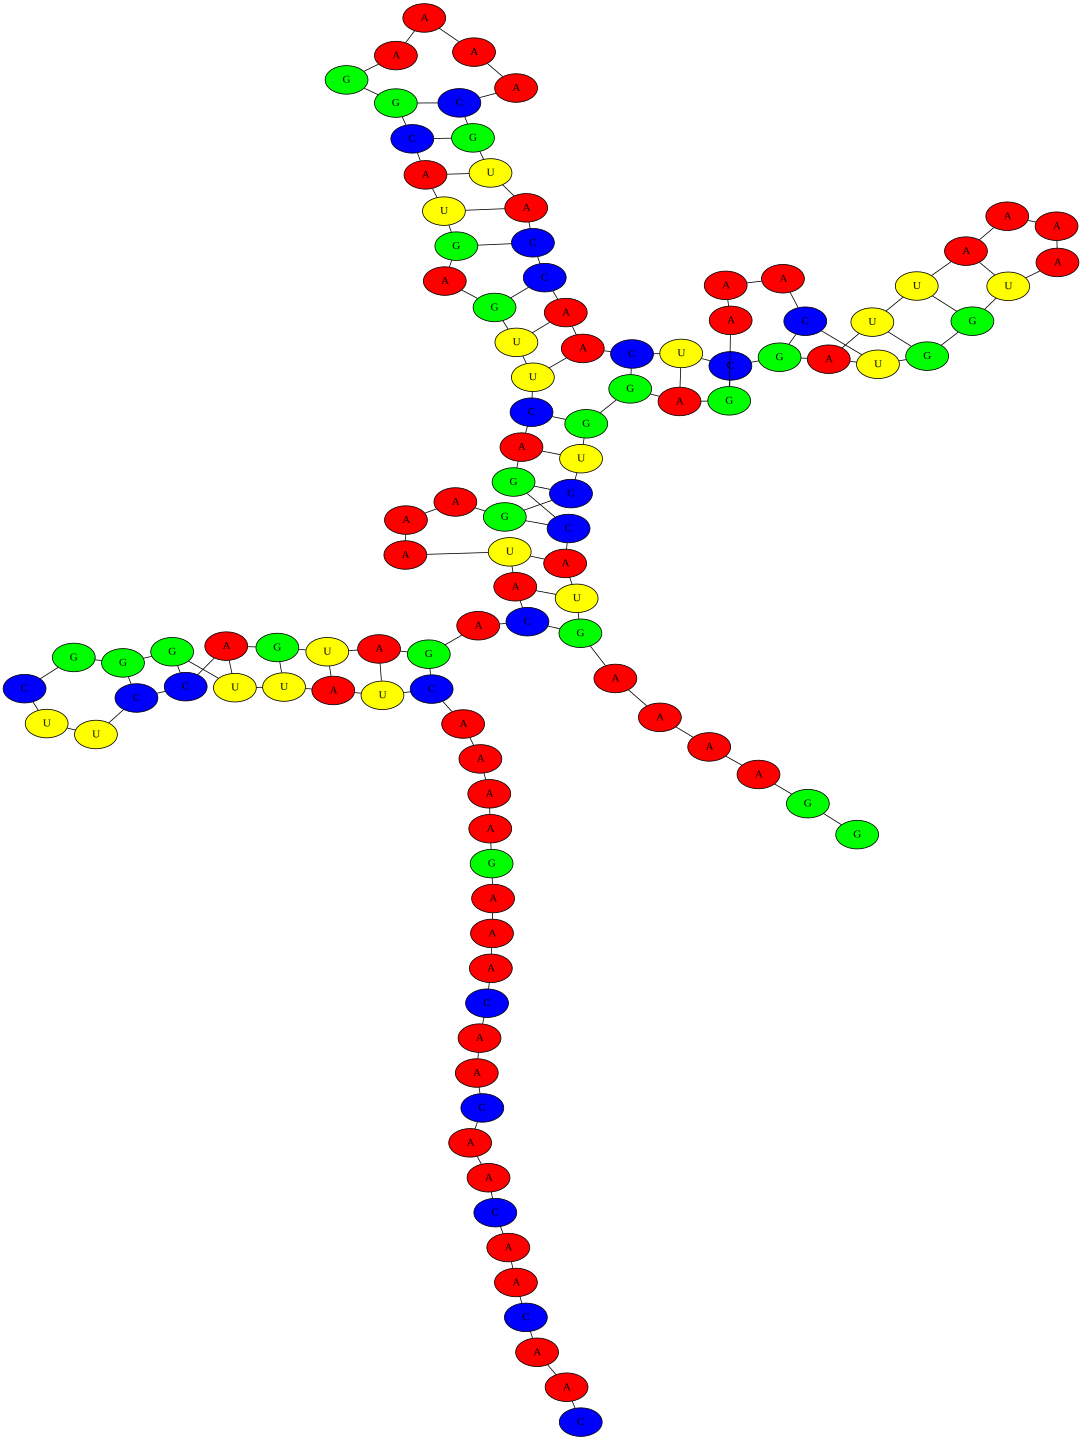

In [20]:
create_graph(raw_test_ds.iloc[0,:])

# Model

In [21]:
print(f"feature_names: {feature_names}")
print(f"error_label_names: {error_label_names}")
print(f"normal_label_names: {normal_label_names}")
print(f"all_label_names: {all_label_names}")
print(f"important_label_names: {important_label_names}")

feature_names: ['sequence', 'structure', 'predicted_loop_type']
error_label_names: ['reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10', 'deg_error_Mg_50C', 'deg_error_50C']
normal_label_names: ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
all_label_names: ['reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10', 'deg_error_Mg_50C', 'deg_error_50C', 'reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
important_label_names: ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C']


### Sequence generator layer

In [254]:
class SequenceGenerator(tf.keras.layers.Layer):
    def __init__(self, rnn, seq_len, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Prepare internal RNN
        self.rnn = rnn
        self.rnn.return_sequences=True
        
        # Define output shape by specifying init_tensor_shape
        self.vec_len = self.rnn.units
        self.init_tensor_shape = [seq_len, 1]
        
        # Initialize random tensor for feeding internal RNN
        self.init_tensor = tf.random.uniform(self.init_tensor_shape)
    
    def call(self, initial_state, training=None, mask=None):
        # Dynamically get a batch size
        batch_size = tf.shape(initial_state[0])[0]
        
        # Dynamically Tile init_tensor to match batch dimension
        init_tensor_batch = tf.reshape(tf.tile(self.init_tensor,[batch_size,1]),
                                       [batch_size] + self.init_tensor_shape)
        
        # Call internal rnn
        output = self.rnn(init_tensor_batch, initial_state=initial_state,
                          training=training, mask=mask)
        
        return output
    
    def get_config(self):
        config = super().get_config()
        config.update({'rnn': self.rnn,
                       'vec_len': self.vec_len,
                       'init_tensor_shape': self.init_tensor_shape,
                       'init_tensor': self.init_tensor.numpy()})
        return config
    
    @classmethod
    def from_config(cls, config):
        config['init_tensor'] = tf.constant(config['init_tensor'])
        return cls(**config)

### Sequence generator layer test

In [255]:
initial_state_h_input = tf.keras.Input(shape=(5))
initial_state_c_input = tf.keras.Input(shape=(5))
initial_state_input = [initial_state_h_input, initial_state_c_input]
print('symbolic initial_state')
initial_state_input

initial_state


[<tf.Tensor 'input_21:0' shape=(None, 5) dtype=float32>,
 <tf.Tensor 'input_22:0' shape=(None, 5) dtype=float32>]

In [256]:
decoder = SequenceGenerator(tf.keras.layers.LSTM(5), seq_len=3)
x = decoder(initial_state=initial_state_input)
x

<tf.Tensor 'sequence_generator_12/lstm_20/PartitionedCall:1' shape=(None, 3, 5) dtype=float32>

In [257]:
# create model for saving
decoder_model = tf.keras.Model(inputs=initial_state_input, outputs=x)

# Save it
model_name = 'decoder_model_test'
model_path = os.path.join(os.getcwd(), model_name)
decoder_model.save(model_path)

# load it back
decoder_model_loaded = tf.keras.models.load_model(model_path)

INFO:tensorflow:Assets written to: /home/jan/kaggle_competitions/covid/decoder_model_test/assets


In [258]:
initial_state_h = tf.constant(np.random.rand(2,5), dtype=tf.float32)
initial_state_c = tf.constant(np.random.rand(2,5), dtype=tf.float32)
initial_state = [initial_state_h, initial_state_c]
print('initial_state')
initial_state

initial_state


[<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[0.9133396 , 0.18571451, 0.12038592, 0.31471592, 0.924522  ],
        [0.25777137, 0.21912448, 0.28267527, 0.8153857 , 0.28457284]],
       dtype=float32)>,
 <tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[0.15725246, 0.18534195, 0.65243125, 0.26261196, 0.62298244],
        [0.29764473, 0.0261195 , 0.18258087, 0.7725228 , 0.51305795]],
       dtype=float32)>]

In [259]:
decoder(initial_state)

<tf.Tensor: shape=(2, 3, 5), dtype=float32, numpy=
array([[[0.10454547, 0.0292006 , 0.20895137, 0.18540269, 0.20003136],
        [0.1055899 , 0.02623466, 0.14460199, 0.16651842, 0.26118565],
        [0.15255594, 0.04141899, 0.14380425, 0.26764074, 0.19913557]],

       [[0.16896185, 0.06968398, 0.05453594, 0.32274577, 0.21609055],
        [0.16512886, 0.07034703, 0.04142964, 0.28266755, 0.20398453],
        [0.20008005, 0.09715781, 0.08859925, 0.3612085 , 0.15194537]]],
      dtype=float32)>

In [260]:
decoder_model(initial_state)

<tf.Tensor: shape=(2, 3, 5), dtype=float32, numpy=
array([[[0.10454547, 0.0292006 , 0.20895137, 0.18540269, 0.20003136],
        [0.1055899 , 0.02623466, 0.14460199, 0.16651842, 0.26118565],
        [0.15255594, 0.04141899, 0.14380425, 0.26764074, 0.19913557]],

       [[0.16896185, 0.06968398, 0.05453594, 0.32274577, 0.21609055],
        [0.16512886, 0.07034703, 0.04142964, 0.28266755, 0.20398453],
        [0.20008005, 0.09715781, 0.08859925, 0.3612085 , 0.15194537]]],
      dtype=float32)>

In [261]:
decoder_model_loaded(initial_state)

<tf.Tensor: shape=(2, 3, 5), dtype=float32, numpy=
array([[[0.10454547, 0.0292006 , 0.20895137, 0.18540269, 0.20003137],
        [0.1055899 , 0.02623466, 0.14460197, 0.16651842, 0.26118562],
        [0.15255593, 0.04141899, 0.14380425, 0.2676407 , 0.19913554]],

       [[0.16896187, 0.06968398, 0.05453594, 0.32274577, 0.21609055],
        [0.16512886, 0.07034703, 0.04142964, 0.28266752, 0.20398451],
        [0.20008004, 0.09715781, 0.08859925, 0.3612085 , 0.15194534]]],
      dtype=float32)>

# Main Model

In [280]:
# INPUTS
INPUT_SEQUENCE_LENGTH = None
sequence_input = Input(shape=(INPUT_SEQUENCE_LENGTH,4),
                       name='sequence')
structure_input = Input(shape=(INPUT_SEQUENCE_LENGTH,3),
                        name='structure')
predicted_loop_type_input = Input(shape=(INPUT_SEQUENCE_LENGTH,7),
                                  name='predicted_loop_type')

inputs = [sequence_input, structure_input, predicted_loop_type_input]

# ACTUAL MODEL
# Stack inputs
stacked_inputs = tf.keras.layers.Concatenate(axis=2, name='input_stacking_layer')(inputs)

vectors_sequence = TimeDistributed(Dense(128), name='vectors_expander')(stacked_inputs)

# Encoder
encoder_LSTM = LSTM(256, return_state=True, name='encoder_LSTM')
_, state_h, state_c = encoder_LSTM(vectors_sequence)

# state_h = Dense(256, activation='relu', name='dense_between_1_h')(state_h)
# state_c = Dense(256, activation='relu', name='dense_between_1_c')(state_c)

# state_h = Dense(128, activation='relu', name='dense_between_2_h')(state_h)
# state_c = Dense(128, activation='relu', name='dense_between_2_c')(state_c)

# Decoder
decoder_LSTM = SequenceGenerator(tf.keras.layers.LSTM(256, name='decoder_LSTM'), seq_len=68, name='decoder')
decoder_outputs = decoder_LSTM(initial_state=[state_h, state_c])

# Dense layers
x = TimeDistributed(Dense(256, activation='relu', name='dense_1'))(decoder_outputs)
x = TimeDistributed(Dense(256, activation='relu', name='dense_2'))(x)

# OUTPUTS
reactivity_pred = TimeDistributed(Dense(1), name='reactivity')(x)
# reactivity_error_pred = TimeDistributed(Dense(1), name='reactivity_error')(x)

deg_Mg_pH10_pred = TimeDistributed(Dense(1), name='deg_Mg_pH10')(x)
# deg_error_Mg_pH10_pred = TimeDistributed(Dense(1), name='deg_error_Mg_pH10')(x)

# deg_pH10_pred = TimeDistributed(Dense(1), name='deg_pH10')(x)
# deg_error_pH10_pred = TimeDistributed(Dense(1), name='deg_error_pH10')(x)

deg_Mg_50C_pred = TimeDistributed(Dense(1), name='deg_Mg_50C')(x)
# deg_error_Mg_50C_pred = TimeDistributed(Dense(1), name='deg_error_Mg_50C')(x)

# deg_50C_pred = TimeDistributed(Dense(1), name='deg_50C')(x)
# deg_error_50C_pred = TimeDistributed(Dense(1), name='deg_error_50C')(x)


# all_outputs = [reactivity_pred, reactivity_error_pred,
#                deg_Mg_pH10_pred, deg_error_Mg_pH10_pred,
#                deg_pH10_pred, deg_error_pH10_pred,
#                deg_Mg_50C_pred, deg_error_Mg_50C_pred,
#                deg_50C_pred, deg_error_50C_pred]

# submission_required_outputs = [reactivity_pred, deg_Mg_pH10_pred, deg_Mg_50C_pred, deg_pH10_pred, deg_50C_pred]

scored_outputs = [reactivity_pred, deg_Mg_pH10_pred, deg_Mg_50C_pred]
stacked_outputs = tf.keras.layers.Concatenate(axis=2, name='stacked_scored_labels')(scored_outputs)


model = Model(inputs=inputs, outputs=stacked_outputs)

model.summary()

Model: "functional_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
structure (InputLayer)          [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
predicted_loop_type (InputLayer [(None, None, 7)]    0                                            
__________________________________________________________________________________________________
input_stacking_layer (Concatena (None, None, 14)     0           sequence[0][0]                   
                                                                 structure[0][0]      

In [281]:
def mcrmse(y_true, y_pred):
    rmse = tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred), axis=1))
    return tf.reduce_mean(rmse, axis=1)

In [282]:
model.compile(loss = mcrmse,
#     loss={'reactivity': 'mse',
#                     'deg_Mg_pH10': 'mse',
#                     'deg_Mg_50C': 'mse'
#                     },
#               optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9),
              optimizer='adam',
#              metrics={'reactivity': tf.keras.metrics.RootMeanSquaredError(),
#                       'deg_Mg_pH10': tf.keras.metrics.RootMeanSquaredError(),
#                       'deg_Mg_50C': tf.keras.metrics.RootMeanSquaredError()}
#               metrics=[mcrmse]
             )

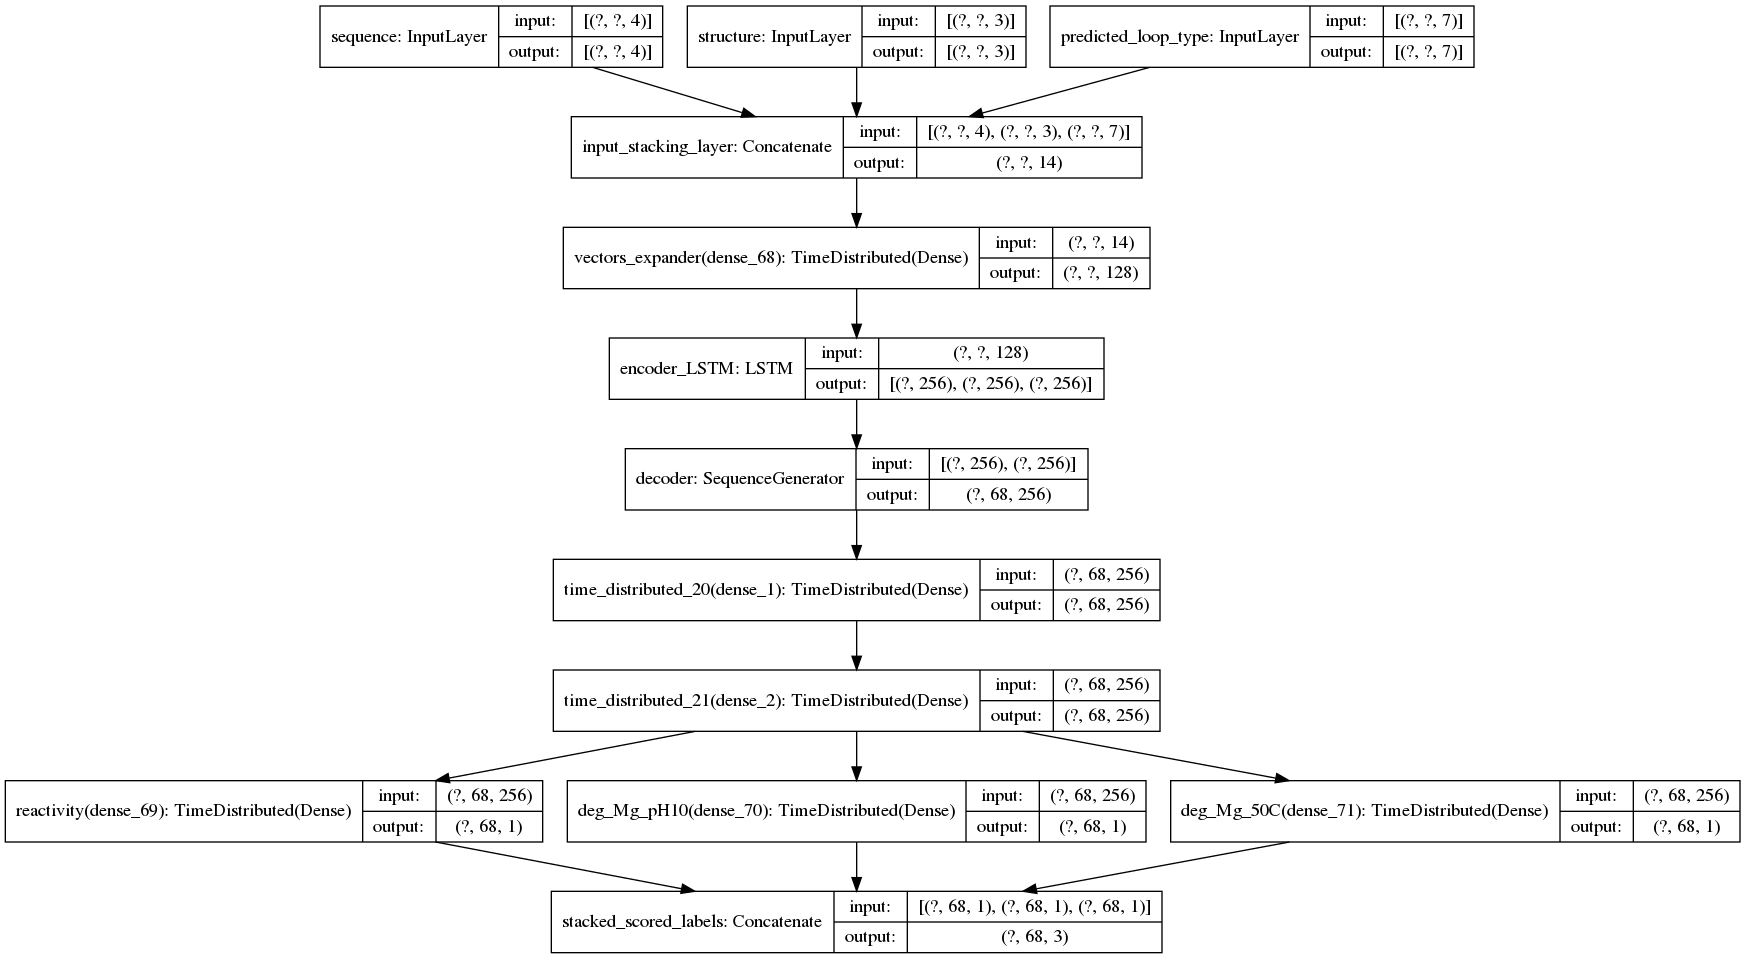

In [283]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Additional dataset preparations

In [266]:
class SelectLabels:
    def __init__(self, choosen_label_names):
        self.choosen_label_names = choosen_label_names

    def __call__(self, x, y):
        y = {label_name: y[label_name] for label_name in self.choosen_label_names}
        return x, y

In [267]:
class SelectFeatures:
    def __init__(self, choosen_feature_names):
        self.choosen_feature_names = choosen_feature_names

    def __call__(self, x, y):
        x = {feature_name: x[feature_name] for feature_name in self.choosen_feature_names}
        return x, y

In [268]:
exp_ds = train_valid_ds.map(SelectFeatures(['sequence'])).map(SelectLabels(['reactivity']))

In [269]:
exp_ds

<MapDataset shapes: ({sequence: (107, 4)}, {reactivity: (68,)}), types: ({sequence: tf.float32}, {reactivity: tf.float32})>

In [270]:
def add_stacked_scored_labels(x, y):
    scored_labels = ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C']
    tensors_to_stack = [y[scored_label] for scored_label in scored_labels]
    stacked_scored_labels = tf.stack(tensors_to_stack, axis=1)
    y.update({'stacked_scored_labels': stacked_scored_labels})
    return x, y

In [271]:
def only_stacked_scored_labels(x, y):
    scored_labels = ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C']
    tensors_to_stack = [y[scored_label] for scored_label in scored_labels]
    stacked_scored_labels = tf.stack(tensors_to_stack, axis=1)
    y = {'stacked_scored_labels': stacked_scored_labels}
    return x, y

In [272]:
train_valid_with_stacked_labels_ds = train_valid_ds.map(only_stacked_scored_labels)

In [273]:
def split_into_train_and_valid(train_valid_ds, split_factor=0.3):
    lenght = train_valid_ds.cardinality().numpy()
    valid_ds_length = int(split_factor*lenght)
    train_valid_ds_shuffled = train_valid_ds.shuffle(lenght)
    train_ds = train_valid_ds_shuffled.skip(valid_ds_length)
    valid_ds = train_valid_ds_shuffled.take(valid_ds_length)
    return train_ds, valid_ds

In [274]:
train_ds, valid_ds = split_into_train_and_valid(train_valid_with_stacked_labels_ds, split_factor=0.3)

In [275]:
print(train_ds.cardinality())
print(train_ds)

tf.Tensor(1680, shape=(), dtype=int64)
<SkipDataset shapes: ({sequence: (107, 4), structure: (107, 3), predicted_loop_type: (107, 7)}, {stacked_scored_labels: (68, 3)}), types: ({sequence: tf.float32, structure: tf.float32, predicted_loop_type: tf.float32}, {stacked_scored_labels: tf.float32})>


In [276]:
print(valid_ds.cardinality())
print(valid_ds)

tf.Tensor(720, shape=(), dtype=int64)
<TakeDataset shapes: ({sequence: (107, 4), structure: (107, 3), predicted_loop_type: (107, 7)}, {stacked_scored_labels: (68, 3)}), types: ({sequence: tf.float32, structure: tf.float32, predicted_loop_type: tf.float32}, {stacked_scored_labels: tf.float32})>


In [277]:
print(test_ds.cardinality())
print(test_ds)

tf.Tensor(3634, shape=(), dtype=int64)
<TensorSliceDataset shapes: {sequence: (None, 4), structure: (None, 3), predicted_loop_type: (None, 7)}, types: {sequence: tf.float32, structure: tf.float32, predicted_loop_type: tf.float32}>


# Model training

In [285]:
log_dir = os.path.join(os.getcwd(), 'logs')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, update_freq='epoch')

In [374]:
history = model.fit(train_ds.batch(64),
          validation_data=valid_ds.batch(64),
          epochs=1000,
          initial_epoch=1101,
          verbose=0,
          shuffle=True,
          callbacks=[tensorboard_callback])

In [286]:
%tensorboard --logdir $log_dir

In [364]:
prediction_ds = test_ds.batch(64)
prediction_ds

<BatchDataset shapes: {sequence: (None, None, 4), structure: (None, None, 3), predicted_loop_type: (None, None, 7)}, types: {sequence: tf.float32, structure: tf.float32, predicted_loop_type: tf.float32}>

In [365]:
predictions = model.predict(prediction_ds)

In [366]:
predictions.shape

(3634, 68, 3)

In [320]:
predictions

array([[[0.57395685, 0.5963726 , 0.52226126],
        [1.8059875 , 2.5482187 , 2.6099076 ],
        [1.3608011 , 0.7604598 , 1.0524179 ],
        ...,
        [0.31150985, 0.5547547 , 0.54034644],
        [0.27459168, 0.5401167 , 0.45657772],
        [0.24251977, 0.7619833 , 0.46580556]],

       [[0.55402726, 0.60977256, 0.5085006 ],
        [1.3937894 , 1.9703289 , 1.7963641 ],
        [1.2738768 , 0.91009563, 1.2766646 ],
        ...,
        [0.3221339 , 0.57322127, 0.56959414],
        [0.28520995, 0.52847195, 0.46894693],
        [0.24953236, 0.726255  , 0.46648967]],

       [[0.46563095, 0.5099158 , 0.45202848],
        [1.4233139 , 1.9959652 , 2.1069584 ],
        [1.2005538 , 0.7649187 , 1.0864925 ],
        ...,
        [0.36451018, 0.59620315, 0.61691993],
        [0.31081676, 0.4922863 , 0.4663982 ],
        [0.27206892, 0.68287593, 0.46350998]],

       [[0.6120336 , 0.6447594 , 0.5293393 ],
        [1.787654  , 2.5465772 , 2.4498258 ],
        [1.3426512 , 0.8044243 , 1.

In [368]:
def get_example_id(example_index, raw_test_ds):
    return raw_test_ds.loc[raw_test_ds['index'] == example_index]['id'].values[0]

In [372]:
def predictions_to_submission(predictions, raw_test_ds, missing_value=0.0):
#     print('id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C')
    submission_dict = {'id_seqpos': [],
                       'reactivity': [],
                       'deg_Mg_pH10': [],
                       'deg_pH10': [],
                       'deg_Mg_50C': [],
                       'deg_50C': []
                       }
    for example_index, example in enumerate(predictions):
        example_id = get_example_id(example_index, raw_test_ds)
        for seqpos_index, (reactivity, deg_Mg_pH10, deg_Mg_50C) in enumerate(example):
            # prepare values
            id_seqpos = f"{example_id}_{seqpos_index}"
            deg_pH10 = missing_value
            deg_50C = missing_value
            
            # add values to submission_dict
            submission_dict['id_seqpos'].append(id_seqpos)
            submission_dict['reactivity'].append(reactivity)
            submission_dict['deg_Mg_pH10'].append(deg_Mg_pH10)
            submission_dict['deg_pH10'].append(deg_pH10)
            submission_dict['deg_Mg_50C'].append(deg_Mg_50C)
            submission_dict['deg_50C'].append(deg_50C)
            
    return pd.DataFrame(submission_dict)

In [373]:
predictions_to_submission(predictions, raw_test_ds)

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.573957,0.596373,0.0,0.522261,0.0
1,id_00073f8be_1,1.805987,2.548219,0.0,2.609908,0.0
2,id_00073f8be_2,1.360801,0.760460,0.0,1.052418,0.0
3,id_00073f8be_3,1.111967,0.682137,0.0,1.005756,0.0
4,id_00073f8be_4,1.024571,1.073192,0.0,1.327538,0.0
...,...,...,...,...,...,...
247107,id_ffda94f24_63,0.147884,0.389414,0.0,0.277071,0.0
247108,id_ffda94f24_64,0.165121,0.445023,0.0,0.369505,0.0
247109,id_ffda94f24_65,0.281419,0.522232,0.0,0.481423,0.0
247110,id_ffda94f24_66,0.259210,0.560817,0.0,0.439161,0.0


In [39]:
model.save('model')

- public train set - 2400 examples of length=107 and scoring_length=68
- public test set - 629 examples of length=107 and scoring_length=68 + 3005 examples of length=130 and scoring_length=91
- private leaderboard test set - 3005 examples of length=130 and scoring_length=91 OR same as public test set ????????????????????

TODO:
* handling different output sequence lengths - output length for submission must be the same as for input - it is 107 in public datasets (but scoring length is 68) and 130 in private (but scoring length is 91):
    - make use of some kind of RNNs for changing sequence length
    - make model that has full length outputs, then use its layers via layers sharing to make model that clip sequences to scoring length, train it and then use original model (with just trained layers via layers sharing) to make predictions for submission:
        - truncating x[:,seq_length]
    - cross-validation - more data to train
* signal_to_noise parameter - maybe it can be used in some way
* unsupervised pretraining - wuju ogarnia
* SequenceGenerator wrapper fix get_config
* SequenceGenerator fix rnn.units handling in case of nested wrapper (e.g. Bidirectional)

